**COSC 44323- Emerging Technologies in Information Technology**

**Mini Project 02 - Stock Price Prediciton System using LSTM Recurrent Neural Networks**

**Student Number: PS/2019/091**

**Student Name: K. G. M. Pinsara**


---









#Importing Relevant Libraries

In [ ]:
import os
import datetime
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

#Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Changing the Current Working Directory

In [ ]:
os.chdir("/content/drive/My Drive/Colab_Data_Files/")
os.getcwd()

'/content/drive/My Drive/Colab_Data_Files'

#Loading and Displaying the Dataset

In [ ]:
# Reading the CSV file into a DataFrame named 'df'
df = pd.read_csv("ABAN.N0000_CSE(2014-2024).csv")

# Displaying DataFrame
df

,Date,Open,High,Low,Close,Volume
0,2014-02-24,101.0,103.0,101.0,101.00,523
1,2014-02-25,99.9,102.9,98.6,99.90,2119
2,2014-02-26,102.4,102.4,98.5,102.40,529
3,2014-02-28,103.8,105.0,101.0,103.80,2535
4,2014-03-03,101.1,104.8,101.0,101.10,109
...,...,...,...,...,...,...
2058,2024-02-16,160.0,165.0,160.0,160.75,384
2059,2024-02-19,165.0,165.0,163.0,164.75,298
2060,2024-02-20,163.0,164.5,163.0,164.75,32
2061,2024-02-21,164.0,164.0,160.5,161.50,313


In [ ]:
df = df[['Date', ' Close']]
df

,Date,Close
0,2014-02-24,101.00
1,2014-02-25,99.90
2,2014-02-26,102.40
3,2014-02-28,103.80
4,2014-03-03,101.10
...,...,...
2058,2024-02-16,160.75
2059,2024-02-19,164.75
2060,2024-02-20,164.75
2061,2024-02-21,161.50


In [ ]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2024-02-24')
datetime_object

datetime.datetime(2024, 2, 24, 0, 0)

In [ ]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

<ipython-input-19-f6fc52bb0fa5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0      2014-02-24
1      2014-02-25
2      2014-02-26
3      2014-02-28
4      2014-03-03
          ...    
2058   2024-02-16
2059   2024-02-19
2060   2024-02-20
2061   2024-02-21
2062   2024-02-22
Name: Date, Length: 2063, dtype: datetime64[ns]

In [ ]:
df.index = df.pop('Date')
df

,Close
Date,
2014-02-24,101.00
2014-02-25,99.90
2014-02-26,102.40
2014-02-28,103.80
2014-03-03,101.10
...,...
2024-02-16,160.75
2024-02-19,164.75
2024-02-20,164.75


In [ ]:
# Displaying the shape (number of rows and columns) of the DataFrame
df.shape

(2063, 1)

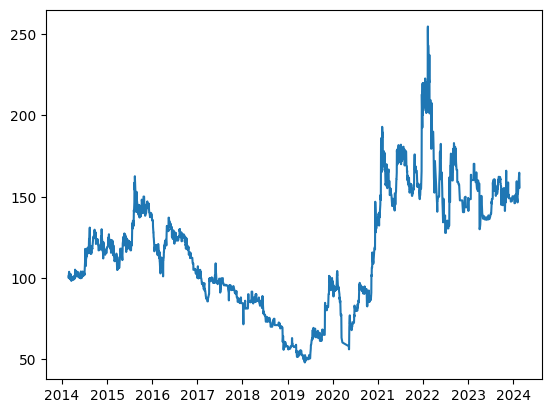

In [ ]:
plt.plot(df.index, df[' Close'])

In [ ]:
# Applying MinMaxScaler to scale down the 'Close' values between 0 and 1 to make them suitable for neural network training
scaler = MinMaxScaler(feature_range=(0,1))

 # Reshaping and transforming the 'Close' values
df = scaler.fit_transform(np.array(df).reshape(-1,1))

# Displaying the transformed 'Close' values
df

array([[0.25634825],
       [0.25102781],
       [0.26311971],
       ...,
       [0.56469166],
       [0.54897219],
       [0.52116082]])

#Train - Test Split

In [ ]:
# Calculating the size of the training data as 80% of the total data
training_size = int(len(df)*0.80)
# Calculating the size of the test data as the remaining 20% of the total data
test_size = len(df)-training_size

# Slicing the DataFrame 'df' to extract the training data and test data based on the calculated sizes
train_data, test_data = df[0:training_size,:], df[training_size:len(df),:1]

# Displaying the sizes of the training data and test data
training_size, test_size

(1650, 413)

#Data Preprocessing

In [ ]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  # Loop through the dataset to create samples with the specified time steps
  for i in range(len(dataset) - time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# Define the number of time steps for creating the dataset matrix
time_step = 100

# Create training and test dataset matrices using the create_dataset function
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# Print the shapes of the training dataset matrices
print(X_train.shape), print(y_train.shape)

(1549, 100)
(1549,)


(None, None)

In [ ]:
# Print the shapes of the test dataset matrices
print(X_test.shape), print(y_test.shape)

(312, 100)
(312,)


(None, None)

##Reshaping the Input to be [Samples, time steps, features] which is required for LSTM

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#Constructing the LSTM Model

In [ ]:
# Create the Stacked LSTM Model

# Initialize a sequential model
model = Sequential()
# Add the first LSTM layer with 50 units, return sequences for the next layer, and specify the input shape
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
# Add the second LSTM layer with 50 units and return sequences
model.add(LSTM(50, return_sequences=True))
# Add the third LSTM layer with 50 units
model.add(LSTM(50))
# Add a dense layer with one neuron for output prediction
model.add(Dense(1))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
# Display the summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Training the Model

In [ ]:
# Train the model using the training data and validate it on the test data
model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
25/25 [==============================] - 12s 267ms/step - loss: 0.0199 - val_loss: 0.0027
Epoch 2/100
25/25 [==============================] - 5s 200ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 3/100
25/25 [==============================] - 4s 179ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/100
25/25 [==============================] - 6s 246ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/100
25/25 [==============================] - 5s 182ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
25/25 [==============================] - 4s 179ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/100
25/25 [==============================] - 8s 309ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 8/100
25/25 [==============================] - 5s 182ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
25/25 [==============================] - 5s 211ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/100
25/25 [==============================] - 5s 214ms/step - loss: 0.0012 - val_l

# Forecasting 'Close' Stock Price Values for the Test Data Set

In [ ]:
# Generate predictions on the training and test datasets using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

10/10 [==============================] - 0s 41ms/step


In [ ]:
# Transform the predicted values back to their original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

#Calculating RMSE

In [ ]:
# Calculate RMSE for training predictions
math.sqrt(mean_squared_error(y_train, train_predict))

115.74977651221968

In [ ]:
# Test data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

153.82224725343377

# Visualizing the Predictions

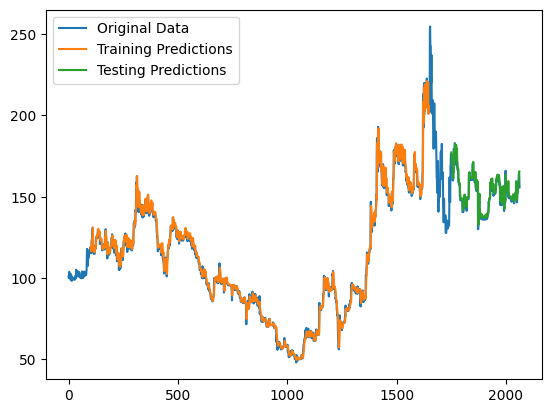

In [44]:
# Define the number of previous time steps used for prediction
look_back=100

# Create arrays to plot the predictions against the original data
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift the test predictions to align them correctly for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict

# Plot the original data, training predictions, and test predictions
plt.plot(scaler.inverse_transform(df)) # Original data
plt.plot(trainPredictPlot) # Training predictions
plt.plot(testPredictPlot) # Test predictions
plt.legend(['Original Data', 'Training Predictions', 'Testing Predictions'])
# Display the plot
plt.show()